# Forecasting Consumption Expenditure for US using ARIMA Modeling

## Introduction

Consumption expenditure/spending is one of the variables of aggregate demand function.  It is a very import index for manufacturers to understand the trend of consumption spending so that they can make adequate preparations to meet the needs of the consumers.

This project takes a look at aggregate consumption spending on non-durable consumer goods for the US economy.  The data which was sourced from Feds was resample from monthly data to quarterly data.  Quarterly forecast of expenditure seems to be more useful for short-term planning purposes and invariably long term purposes.

Import the necessary libraries

In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.4 MB/s 
     |████████████████████████████████| 9.8 MB 41.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import and examine the datasets

In [3]:
data = pd.read_csv("/content/drive/MyDrive/Time Series/Macroseries/NondurablePCE.csv",index_col='Date',parse_dates=True)
data.head()

,PCEX
Date,
1947-01-01,17239
1947-04-01,18813
1947-07-01,18933
1947-10-01,22610
1948-01-01,19078


In [4]:
data.tail()

,PCEX
Date,
2020-10-01,831803
2021-01-01,771813
2021-04-01,852972
2021-07-01,869225
2021-10-01,963106


In [6]:
data.index.freq='QS'

# Visualize the dataset

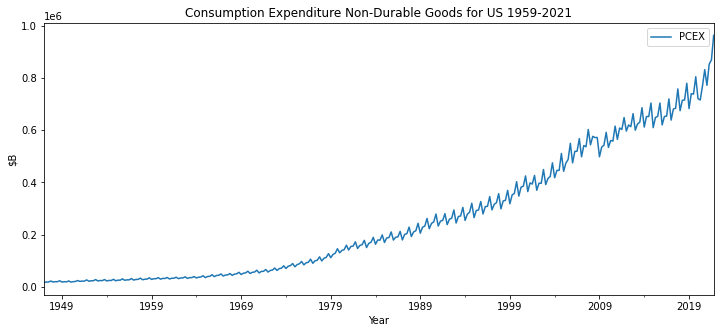

In [13]:
title='Consumption Expenditure Non-Durable Goods for US 1959-2021'
ylabel='$B'
xlabel='Year'

ax = data.plot(figsize=(12,5),title=title)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.autoscale(axis='x',tight=True);

A casual inspection of the data shows a linear trend and seasonality.  But we will use the seasonal decompose library to look further into this.

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

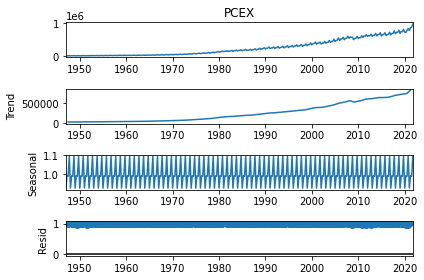

In [15]:
data_decomp = seasonal_decompose(data['PCEX'],model='mult')
data_decomp.plot();

# Modelling

In order to model this time series data, we need to take into congnizance the presence of trend and seasonality.  While the ACF and the PACF curves provides the classical evalution of the order of ARIMA model, we shall use the auto-arima package to pick our order of pdq.

In [16]:
from pmdarima.arima import auto_arima

In [17]:
result = auto_arima(data['PCEX'],seasonal=True,m=4)
print(result.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  300
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood               -3088.650
Date:                           Sat, 12 Mar 2022   AIC                           6183.301
Time:                                   17:37:56   BIC                           6194.361
Sample:                                        0   HQIC                          6187.730
                                           - 300                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1085      0.025     -4.293      0.000      -0.158      -0.059
ma.S.L4       -0.6514      0.027    -24.554

auto-arima suggest an order of 0,1,1 by 0,1,1,4 for our modeling.

# Split the data into training and testing sets

In [18]:
len(data)

300

Since we have a quartely dataset, we shall forecast for 8 quarters, meaning 2 years.

In [19]:
train_df = data[:-8]
test_df = data[-8:]

In [20]:
print(train_df.shape,test_df.shape)

(292, 1) (8, 1)


# Fit the model with SARIMAX model

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

In [22]:
model = SARIMAX(train_df['PCEX'],order=(0,1,1),seasonal_order=(0,1,1,4),enforce_invertibility=False)
model_res = model.fit()
print(model_res.summary())

                                     SARIMAX Results                                     
Dep. Variable:                              PCEX   No. Observations:                  292
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood               -2923.660
Date:                           Sat, 12 Mar 2022   AIC                           5853.320
Time:                                   17:47:38   BIC                           5864.299
Sample:                               01-01-1947   HQIC                          5857.720
                                    - 10-01-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0228      0.052     -0.434      0.665      -0.126       0.080
ma.S.L4       -0.5162      0.036    -14.328

Check the diagnostics

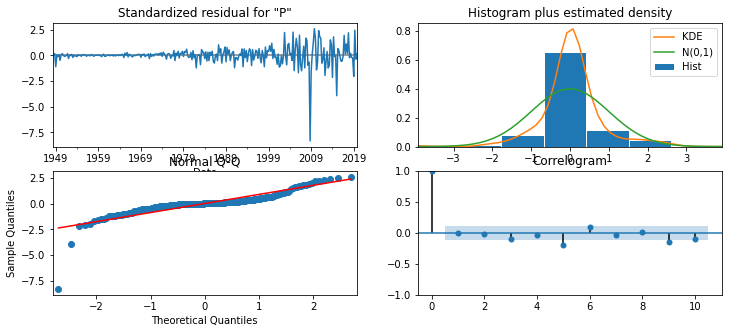

In [24]:
model_res.plot_diagnostics(figsize=(12,5));

One of the takeways of seasonal ARIMA model is that the residuals of the model should be uncorrelated and normally distributed with zero mean.  If this conditions are not met, it is an indication that the model can further be improved.

In our model, the diagnostics shows that the residuals are normally distributed going by the KDE plot on the top right corner where the KDE line closely follows a normal distribution with N(0,1).

Furthermore, the QQ plot at the bottom left of the plot shows that almost all the blue dots lies on the red line which indicates that the sample was drawn from a normal distribution.

The residuals at the top left corner did not show any signs of seasonality which indicates a white noise.

# Obtain the Predictions

In [25]:
start = len(train_df)
end = len(train_df)+len(test_df)-1
pred = model_res.predict(start=start,end=end,dynamic=False).rename('Predictions')

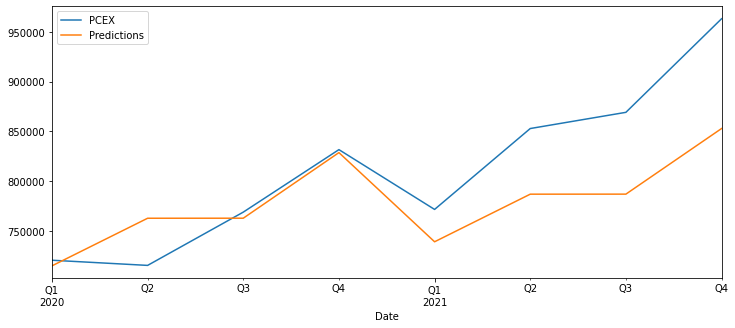

In [26]:
test_df['PCEX'].plot(figsize=(12,5),legend=True)
pred.plot(legend=True);

The predictions looks pretty good till the end of the 4th quarter of 2020 before we started noticing some wider divergence between forecasted and real consumption expenditure.  However, we consider the first year of the prediction, it looks more precise.

In [32]:
test_df['pred'] = pred
test_df['error (%)'] = abs((test_df['PCEX']-test_df['pred'])/test_df['PCEX'])*100

In [30]:
test_df = test_df.drop('error',axis=1)

In [31]:
test_df

,PCEX,pred,error (%)
Date,,,
2020-01-01,720845,715212.078425,0.781433
2020-04-01,715663,762967.467234,6.609880
2020-07-01,769103,763006.414387,0.792688
2020-10-01,831803,828826.047134,0.357892
2021-01-01,771813,739360.439613,4.204718
2021-04-01,852972,787115.828422,7.720789
2021-07-01,869225,787154.775575,9.441770
2021-10-01,963106,852974.408321,11.435044


# Model Evaluation

In [33]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

In [34]:
mse = mean_squared_error(test_df['PCEX'],pred)
rmser = rmse(test_df['PCEX'],pred)

print(f'mean_squared_error : {mse}')
print(f'root_mean_squared_error: {rmser}')

mean_squared_error : 3321270782.9835477
root_mean_squared_error: 57630.46748885131


# Conclusions

Our forecasting did some pretty good job even though it could not go with more precision into the second year of the forecasting period.  In predicting consumption, one should not rely majorly on ARIMA model alone because there are certain exogenous factors that influence consumption decisions such as, government policy in terms of taxes, unemployment allowance, and others; personal disposable income, consumer confidence etc.  These factors, when included into the model can ensure a more precise forecasting of the estimates.

Thanks for reading.